# Household Power Consumption LSTM Predictor - Optimized Version

This notebook demonstrates an optimized LSTM model for predicting household power consumption. Key optimizations include data sampling, resampling, a smaller model, and concise visualizations.

In [1]:
# Import Libraries and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Configure TensorFlow for better performance
tf.config.experimental.enable_memory_growth = True
tf.config.set_visible_devices([], 'GPU')  # Use CPU for stability

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("🚀 Libraries loaded successfully!")

🚀 Libraries loaded successfully!


## Data Loading and Preprocessing

Load and preprocess the data, including sampling and resampling for faster training.

In [2]:
def load_and_preprocess_data(file_path, sample_fraction=0.3, resample_freq='5T'):
    """
    Load and preprocess data with sampling for faster training
    
    Args:
        file_path: Path to the data file
        sample_fraction: Fraction of data to use (0.3 = 30% of data)
        resample_freq: Resampling frequency ('5T' = 5 minutes)
    """
    print(f"📊 Loading data with {sample_fraction*100}% sampling...")
    
    # Load data
    df = pd.read_csv(file_path, sep=';', low_memory=False)
    
    # Convert date and time
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], 
                                   format='%d/%m/%Y %H:%M:%S')
    df.set_index('DateTime', inplace=True)
    df.drop(['Date', 'Time'], axis=1, inplace=True)
    
    # Replace '?' with NaN and convert to numeric
    df = df.replace('?', np.nan)
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # Handle missing values
    df = df.interpolate(method='linear')
    df = df.fillna(method='ffill').fillna(method='bfill')
    
    # Sample data for faster training
    if sample_fraction < 1.0:
        df = df.sample(frac=sample_fraction, random_state=42).sort_index()
    
    # Resample to reduce data points (e.g., every 5 minutes instead of every minute)
    df = df.resample(resample_freq).mean()
    
    # Remove outliers (simplified method)
    df = df[(np.abs(df - df.mean()) <= 3 * df.std()).all(axis=1)]
    
    print(f"✅ Data processed. Final shape: {df.shape}")
    print(f"📅 Date range: {df.index.min()} to {df.index.max()}")
    
    return df

# Load data with sampling
df = load_and_preprocess_data(r'D:\Download\aiSummerCamp2025-master\clonetest\aiSummerCamp2025\day3\assignment\data\household_power_consumption\household_power_consumption.txt', 
                             sample_fraction=0.2,  # Use only 20% of data
                             resample_freq='10T')   # Resample to 10-minute intervals

📊 Loading data with 20.0% sampling...
✅ Data processed. Final shape: (172665, 7)
📅 Date range: 2006-12-16 17:50:00 to 2010-11-26 20:40:00


## Quick Data Visualization

Visualize the main features of the dataset.

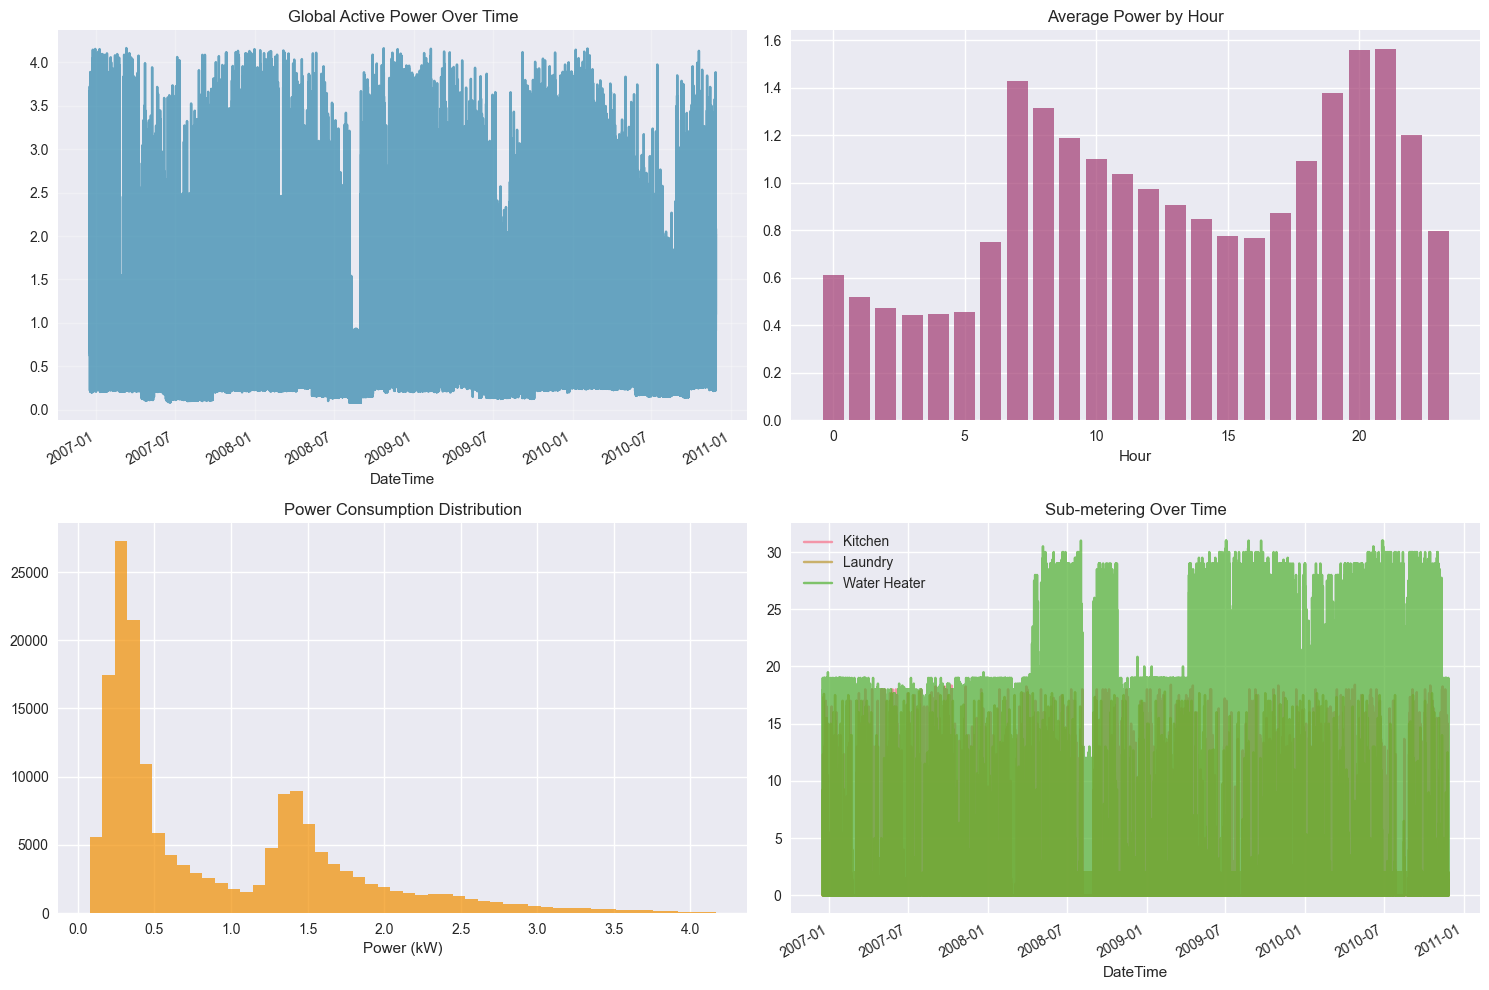

In [3]:
def create_quick_visualizations(df):
    """Create essential visualizations quickly"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Global Active Power
    df['Global_active_power'].plot(ax=axes[0,0], color='#2E86AB', alpha=0.7)
    axes[0,0].set_title('Global Active Power Over Time')
    axes[0,0].grid(True, alpha=0.3)
    
    # Daily pattern
    hourly_pattern = df.groupby(df.index.hour)['Global_active_power'].mean()
    axes[0,1].bar(hourly_pattern.index, hourly_pattern.values, color='#A23B72', alpha=0.7)
    axes[0,1].set_title('Average Power by Hour')
    axes[0,1].set_xlabel('Hour')
    
    # Distribution
    axes[1,0].hist(df['Global_active_power'].dropna(), bins=50, 
                   color='#F18F01', alpha=0.7)
    axes[1,0].set_title('Power Consumption Distribution')
    axes[1,0].set_xlabel('Power (kW)')
    
    # Sub-metering
    df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].plot(ax=axes[1,1], 
                                                                     alpha=0.7)
    axes[1,1].set_title('Sub-metering Over Time')
    axes[1,1].legend(['Kitchen', 'Laundry', 'Water Heater'])
    
    plt.tight_layout()
    plt.show()

create_quick_visualizations(df)

## Optimized LSTM Model Class

Define the LSTM predictor class with all necessary methods.

In [4]:
class OptimizedLSTMPredictor:
    def __init__(self, sequence_length=24):  # Reduced from 60 to 24
        self.sequence_length = sequence_length
        self.scaler = MinMaxScaler()
        self.model = None
        
    def prepare_data(self, df, target_col='Global_active_power'):
        """Prepare data for LSTM with optimizations"""
        print("🔧 Preparing LSTM data...")
        
        # Select key features only
        features = ['Global_active_power', 'Global_reactive_power', 
                   'Voltage', 'Global_intensity']
        
        data = df[features].values
        scaled_data = self.scaler.fit_transform(data)
        
        # Create sequences
        X, y = [], []
        for i in range(self.sequence_length, len(scaled_data)):
            X.append(scaled_data[i-self.sequence_length:i])
            y.append(scaled_data[i, 0])
        
        X, y = np.array(X), np.array(y)
        
        # Split data
        split_idx = int(len(X) * 0.8)
        self.X_train, self.X_test = X[:split_idx], X[split_idx:]
        self.y_train, self.y_test = y[:split_idx], y[split_idx:]
        
        print(f"✅ Training samples: {len(self.X_train)}, Test samples: {len(self.X_test)}")
        return self.X_train, self.y_train, self.X_test, self.y_test
    
    def build_model(self):
        """Build optimized LSTM model"""
        print("🏗️ Building optimized LSTM model...")
        
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(self.sequence_length, 4)),
            Dropout(0.2),
            LSTM(30, return_sequences=False),
            Dropout(0.2),
            Dense(15),
            Dense(1)
        ])
        
        model.compile(optimizer=Adam(learning_rate=0.001), 
                     loss='mse', metrics=['mae'])
        
        self.model = model
        print("✅ Model built successfully!")
        return model
    
    def train_model(self, epochs=30, batch_size=64, verbose=0):
        """Train model with minimal output"""
        print("🚀 Training model (this may take a few minutes)...")
        
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, 
                                      restore_best_weights=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                     patience=5, min_lr=0.0001, verbose=0)
        
        # Train with minimal output
        history = self.model.fit(
            self.X_train, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(self.X_test, self.y_test),
            callbacks=[early_stopping, reduce_lr],
            verbose=verbose  # 0 = silent, 1 = progress bar, 2 = one line per epoch
        )
        
        self.history = history
        print("✅ Training completed!")
        return history
    
    def evaluate_model(self):
        """Evaluate model performance"""
        print("📊 Evaluating model...")
        
        # Predictions
        train_pred = self.model.predict(self.X_train, verbose=0)
        test_pred = self.model.predict(self.X_test, verbose=0)
        
        # Inverse transform
        def inverse_transform_predictions(predictions, actual):
            pred_full = np.zeros((len(predictions), 4))
            pred_full[:, 0] = predictions.flatten()
            pred_inverse = self.scaler.inverse_transform(pred_full)[:, 0]
            
            actual_full = np.zeros((len(actual), 4))
            actual_full[:, 0] = actual
            actual_inverse = self.scaler.inverse_transform(actual_full)[:, 0]
            
            return pred_inverse, actual_inverse
        
        train_pred_inv, train_actual_inv = inverse_transform_predictions(train_pred, self.y_train)
        test_pred_inv, test_actual_inv = inverse_transform_predictions(test_pred, self.y_test)
        
        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(train_actual_inv, train_pred_inv))
        test_rmse = np.sqrt(mean_squared_error(test_actual_inv, test_pred_inv))
        test_mae = mean_absolute_error(test_actual_inv, test_pred_inv)
        test_r2 = r2_score(test_actual_inv, test_pred_inv)
        
        print(f"📈 Model Performance:")
        print(f"   Test RMSE: {test_rmse:.4f}")
        print(f"   Test MAE: {test_mae:.4f}")
        print(f"   Test R²: {test_r2:.4f}")
        
        # Store for plotting
        self.test_predictions = test_pred_inv
        self.test_actual = test_actual_inv
        
        return {'test_rmse': test_rmse, 'test_mae': test_mae, 'test_r2': test_r2}
    
    def plot_results(self):
        """Create concise result plots"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Training history
        axes[0].plot(self.history.history['loss'], label='Training Loss', color='#2E86AB')
        axes[0].plot(self.history.history['val_loss'], label='Validation Loss', color='#A23B72')
        axes[0].set_title('Training Progress')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Predictions vs Actual (sample)
        sample_size = min(500, len(self.test_actual))
        axes[1].plot(self.test_actual[:sample_size], label='Actual', color='#2E86AB', alpha=0.7)
        axes[1].plot(self.test_predictions[:sample_size], label='Predicted', color='#A23B72', alpha=0.7)
        axes[1].set_title(f'Predictions vs Actual (First {sample_size} samples)')
        axes[1].set_xlabel('Time Steps')
        axes[1].set_ylabel('Power (kW)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Scatter plot
        axes[2].scatter(self.test_actual[::10], self.test_predictions[::10], 
                       alpha=0.6, color='#2E86AB', s=10)
        axes[2].plot([self.test_actual.min(), self.test_actual.max()], 
                    [self.test_actual.min(), self.test_actual.max()], 
                    'r--', linewidth=2)
        axes[2].set_title('Predicted vs Actual')
        axes[2].set_xlabel('Actual')
        axes[2].set_ylabel('Predicted')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def predict_future(self, steps=24):
        """Predict future values"""
        print(f"🔮 Predicting next {steps} steps...")
        
        last_sequence = self.X_test[-1].reshape(1, self.sequence_length, 4)
        predictions = []
        
        for _ in range(steps):
            pred = self.model.predict(last_sequence, verbose=0)
            predictions.append(pred[0, 0])
            
            # Update sequence
            new_row = last_sequence[0, -1].copy()
            new_row[0] = pred[0, 0]
            last_sequence = np.roll(last_sequence, -1, axis=1)
            last_sequence[0, -1] = new_row
        
        # Inverse transform
        pred_full = np.zeros((len(predictions), 4))
        pred_full[:, 0] = predictions
        future_pred = self.scaler.inverse_transform(pred_full)[:, 0]
        
        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(future_pred, marker='o', color='#2E86AB', linewidth=2, markersize=4)
        plt.title(f'Future Power Consumption Prediction ({steps} steps ahead)')
        plt.xlabel('Time Steps')
        plt.ylabel('Power (kW)')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return future_pred

## Initialize and Train Model

Prepare the data, build the model, and start training.

In [5]:
predictor = OptimizedLSTMPredictor(sequence_length=24)

# Prepare data
X_train, y_train, X_test, y_test = predictor.prepare_data(df)

# Build model
model = predictor.build_model()

🔧 Preparing LSTM data...
✅ Training samples: 138112, Test samples: 34529
🏗️ Building optimized LSTM model...
✅ Model built successfully!


## Train Model

Train the LSTM model with minimal output.

In [6]:
print("🎯 Starting training with minimal output...")
history = predictor.train_model(epochs=25, batch_size=64, verbose=2)  # verbose=2 for one line per epoch

🎯 Starting training with minimal output...
🚀 Training model (this may take a few minutes)...
Epoch 1/25
2158/2158 - 14s - 7ms/step - loss: 0.0116 - mae: 0.0680 - val_loss: 0.0077 - val_mae: 0.0563 - learning_rate: 1.0000e-03
Epoch 2/25
2158/2158 - 13s - 6ms/step - loss: 0.0100 - mae: 0.0604 - val_loss: 0.0081 - val_mae: 0.0534 - learning_rate: 1.0000e-03
Epoch 3/25
2158/2158 - 13s - 6ms/step - loss: 0.0099 - mae: 0.0597 - val_loss: 0.0075 - val_mae: 0.0527 - learning_rate: 1.0000e-03
Epoch 4/25
2158/2158 - 13s - 6ms/step - loss: 0.0098 - mae: 0.0593 - val_loss: 0.0076 - val_mae: 0.0532 - learning_rate: 1.0000e-03
Epoch 5/25
2158/2158 - 14s - 6ms/step - loss: 0.0098 - mae: 0.0591 - val_loss: 0.0076 - val_mae: 0.0509 - learning_rate: 1.0000e-03
Epoch 6/25
2158/2158 - 14s - 7ms/step - loss: 0.0097 - mae: 0.0589 - val_loss: 0.0076 - val_mae: 0.0557 - learning_rate: 1.0000e-03
Epoch 7/25
2158/2158 - 14s - 6ms/step - loss: 0.0097 - mae: 0.0587 - val_loss: 0.0075 - val_mae: 0.0514 - learning_

## Evaluate and Visualize Results

Evaluate the model and visualize the results.

📊 Evaluating model...
📈 Model Performance:
   Test RMSE: 0.3530
   Test MAE: 0.2148
   Test R²: 0.7285


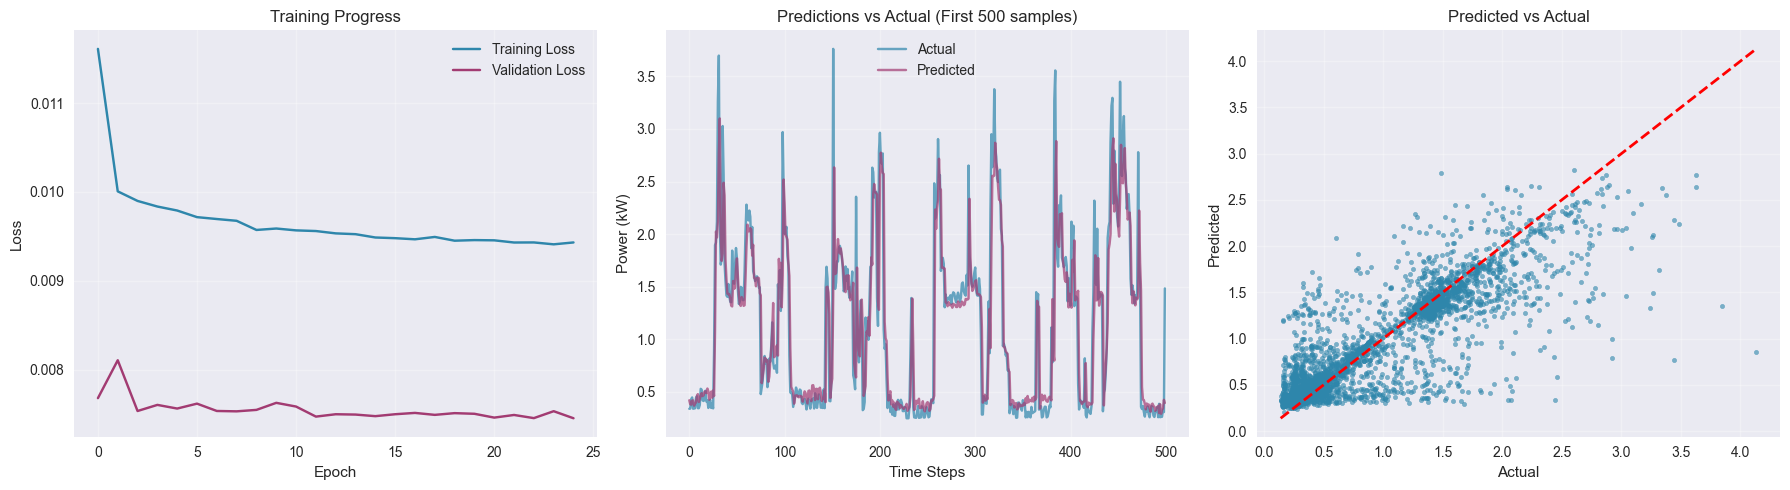

In [7]:
metrics = predictor.evaluate_model()
predictor.plot_results()

## Future Predictions

Predict future power consumption for the next 24 steps.

🔮 Predicting next 24 steps...


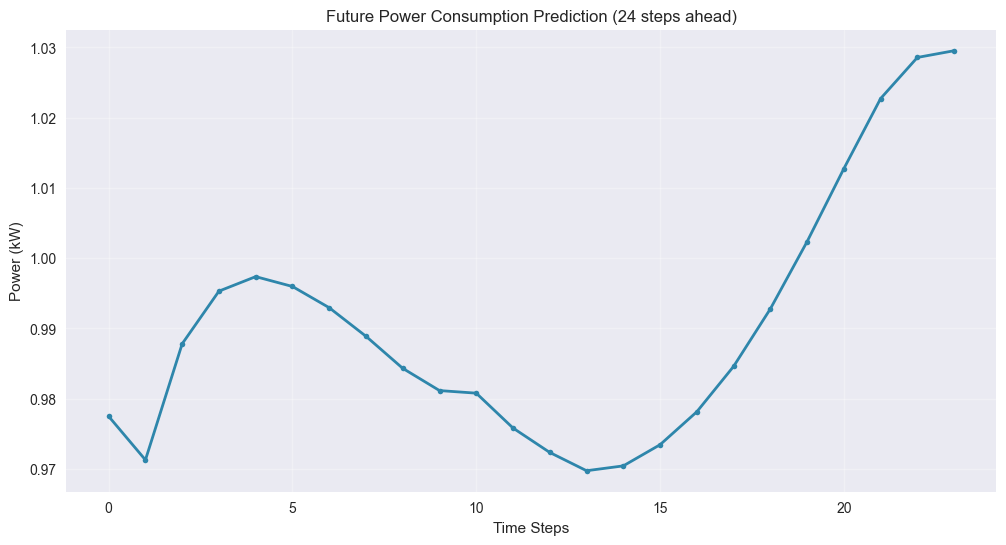

📊 Future predictions (next 24 steps): [0.97746873 0.97126554 0.98780531 0.99530023 0.99736522]...


In [8]:
future_predictions = predictor.predict_future(steps=24)
print(f"📊 Future predictions (next 24 steps): {future_predictions[:5]}...")

## Save Model

Save the trained model to disk.

In [9]:
predictor.model.save('optimized_power_lstm_model.h5')
print("✅ Model saved successfully!")

print("\n🎉 Optimized LSTM training completed!")
print("💡 Key optimizations applied:")
print("   - Reduced data sampling (20% of original)")
print("   - Resampled to 10-minute intervals")
print("   - Smaller model architecture")
print("   - Reduced sequence length (24 vs 60)")
print("   - Minimal training output")
print("   - Essential visualizations only")

✅ Model saved successfully!

🎉 Optimized LSTM training completed!
💡 Key optimizations applied:
   - Reduced data sampling (20% of original)
   - Resampled to 10-minute intervals
   - Smaller model architecture
   - Reduced sequence length (24 vs 60)
   - Minimal training output
   - Essential visualizations only
